In [1]:
from scipy.integrate import ode
from scipy.interpolate import interp1d
import pandas as pd
from astropy import units as u
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from scipy.optimize import minimize, approx_fprime

In [2]:
import matplotlib as mpl
# mpl.rcParams['figure.dpi'] = 1000
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.autolayout'] = True 
# mpl.rcParams['axes.spines.right'] = False
# mpl.rcParams['axes.spines.top'] = False


# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "sans-serif",
#     "font.sans-serif": ["Helvetica"]})

# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Palatino"],
# })

def utkarshGrid():
    plt.minorticks_on()
    plt.grid(color='grey',
             which='minor',
             linestyle=":",
             linewidth='0.1',
             )
    plt.grid(color='black',
             which='major',
             linestyle=":",
             linewidth='0.1',
             )

In [3]:
G = 6.67259e-8 # dyne cm2 g-2
c = 2.998e10 # cms-1
n_den = 2.3e14
km2cm = 1e5
# G = c = 1

def lamba_metric(M, R):
    return -0.5*np.log((1-2*G*M/(c**2*R)))

In [4]:
# Working in manual cgs units here. 

# DIMENSIONS CHECKED
def _dMdr(r, e):
    return 4 * np.pi * r**2 * (e/(c**2))

# DIMENSIONS CHECKED
def _dPhidr(r, P, M):
    factor1 = G/(c**2) 
    num = (M+4*np.pi*(r**3)*P/(c**2))
    dem = r * (r-2*G*M/(c**2))
    return factor1*num/dem

# DIMENSIONS CHECKED
def _dPdr(r, P, M, e):
    factor2 = -1 # factor goes in dphi/dr
    term1 = (e+P) 
    dphidr = _dPhidr(r, P, M)
    return factor2 * term1 * dphidr

# DIMENSIONS CHECKED
def _dWdr(r, V, W, phi, dphidr, drhodp, omega, lamda, l):
    term1 = (omega**2) * (r**2) * np.exp(lamda - 2*phi)*V
    term2 = dphidr * W * (c**2)
    brackets = term1 + term2
    ret = drhodp * brackets - l*(l+1)*np.exp(lamda)*V
    return ret

# DIMENSIONS CHECKED
def _dVdr(r, V, W, dphidr, lamda):
    return 2*dphidr*V - np.exp(lamda)*(W/(r**2))

def coupledTOV(r, VEC, init_params):
    P, M, phi, W, V = VEC
    EOS, l, omega = init_params
    lamda = lamba_metric(M, r)
    
    e = EOS(P)

    eps = 1e15
    p_eval = np.linspace(p[i]/eps, p[i]*eps, 10)
    e_eval = EOS(p_eval)
    dedp = np.mean(np.gradient(e_eval, p_eval, edge_order=2))

#     dedp = approx_fprime(P, EOS, epsilon = eps)

#     #Ideally you need to remove this once you fixed w, v plots. 
#     dedp = min(dedp, 1) # UNPHYSICAL BUT USED TO SATISFY BAD BOUNDARY BEHAVIOUR
    
    drhodp = dedp / (c**2)
    
    dPdr = _dPdr(r, P, M, e)
    dMdr = _dMdr(r, e)
    dPhidr = _dPhidr(r, P, M)
    dWdr = _dWdr(r, V, W, phi, dPhidr, drhodp, omega, lamda, l)
    dVdr = _dVdr(r, V, W, dPhidr, lamda)
    ret = [dPdr, dMdr, dPhidr, dWdr, dVdr]
    return ret

In [5]:
def df_to_ep(df):
    n_den = 2.3e14
    e_den = df.energy_densityc2
    e_den_normed = e_den#/n_den
    p = df.pressurec2
    e_den_normed = e_den_normed*((2.998e10)**2)
    pressure = p*((2.998e10)**2)
    return e_den_normed.to_numpy(), pressure.to_numpy()

def get_ep(e, p):
    # CHOICE OF INTERPOLATION PLAYS A VERY IMPORTANT ROLE IN F-MODE. 
    f_e_smooth = interp1d(p, e, fill_value=(0, 0), bounds_error=False)
#     f_e_smooth = interp1d(p, e, fill_value = "extrapolate")
    return f_e_smooth

##### Sanity check that my gradient is working. 

100%|██████████| 225/225 [00:00<00:00, 2766.34it/s]


Text(0, 0.5, '1/cs^2')

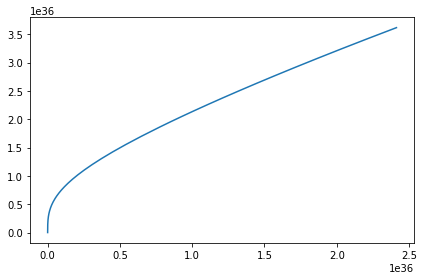

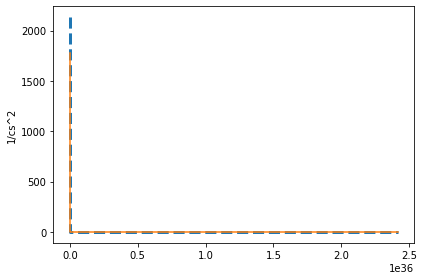

In [6]:
df = pd.read_csv("eos_data/sly230a.csv")
e, p = df_to_ep(df)
EOS = get_ep(e, p)
plt.plot(p, e)
# plt.axvline(x=min(p))
plt.figure()
dedp = np.zeros(len(p))
dedp2 = np.zeros(len(p))
for i in tqdm(range(len(p))):
    
    # THIS CHOICE WAS NON-TRIVIAL: SCALE WITH ORDERS OF MAGNITUDE
    eps = 1e15
    p_eval = np.linspace(p[i]/eps, p[i]*eps, 10)
    e_eval = EOS(p_eval)
    dedp[i] = np.mean(np.gradient(e_eval, p_eval, edge_order=2))
    dedp2[i] = approx_fprime(np.mean(p_eval), EOS, epsilon = eps)

plt.plot(p, dedp, linestyle = "dashed", linewidth = 3)
plt.plot(p, dedp2)
# plt.xlim(0, 1e36)
# plt.ylim(0, 10)
plt.ylabel("1/cs^2")

In [7]:
def tov(ep, init_VEC, r_i, p_min, omega, progress = False, 
        l=2, n_iter_max = 5000):
    
    init_params = [ep, l, omega]

    r = ode(lambda r, VEC: coupledTOV(r, VEC, init_params)).set_integrator('LSODA')
    r.set_initial_value(init_VEC, r_i)

    results = []
    r_list = []

    i = 0
    r_max = 20 * km2cm
    # max_iter = 1000000 # Change back to this if "Excess work done on this call" error. 
    max_iter = n_iter_max

    dr_init = r_max/max_iter
    dr_compute = 1000
    
    if progress:
        pbar = tqdm(total=max_iter)

    while r.successful() and (r.y[0] >= p_min):
        i+=1

        dr = min(dr_init, dr_compute)

        integral = r.integrate(r.t+dr)
        
        
#         dr_compute = #r * dP /P 

        if progress:
            pbar.update(1)
        if i > max_iter:
            print("[STATUS] max_iter reached")
            break
            
        if (r.y[0] < p_min):
            break
        
        results.append(integral)
        r_list.append(r.t+dr_init)
        
    if progress:
        pbar.close()
        
#     print(r.successful() , (r.y[0] > p_min))
    
    
    results = np.array(results, dtype = float)
    p, m, phi, w, v = results.T
    r = np.array(r_list)
    return p, m, r, phi, w, v

In [8]:
# Load EOS
df = pd.read_csv("eos_data/sly230a.csv")
e, p = df_to_ep(df)
EOS = get_ep(e, p)

# Initial Conditions
km2cm = 1e5
r_i = 1
p0 = p[-24]
e0 = EOS(p0)
p_c = p0 - 2 * np.pi * (G/(c**4)) * r_i**2 * (p0 + e0) * (3*p0 + e0)/3
e_c = e0
m0 = e_c/(c**2) * 4/3 * np.pi * r_i**3

phi0 = -1 #Arbitrary guess 
omega = 1e3*(2*np.pi) #Arbitrary guess

C = 1 # Arbitrary constant
l = 2
W0 =  C   * r_i ** (l+1)
V0 = -C/l * r_i ** (l)

init_VEC = [p_c, m0, phi0, W0, V0]
msun = 2e33
p_min = min(p) 

M_guess = 1.4 * msun
R_guess = 10 * km2cm

# Integrate
p, m, r_arr, phi, w, v = tov(EOS, init_VEC, r_i, p_min, omega,progress = True, 
                             l = l, n_iter_max = 2000)

max_idx = np.argmax(m)
m_R = m.max() # In units of msun
r_R = r_arr[max_idx] # In units of km
p_R = p[max_idx] #cgs
ec_R = EOS(p_R) #cgs
phi_R = phi[max_idx] #cgs
v_R = v[max_idx]
w_R = w[max_idx]

schild = (1-2*G*m_R/(c**2*r_R))
interior = np.exp(2*phi[-1])

# Log base e
phi_ext = 0.5 * np.log(schild) #At surface
phi_int = phi[-1] #At surface


# DIMENSIONED CHECKED
def boundary_wv(r_R, p_R, m_R, omega, phi_int, v_R):
    dPhidr_R = _dPhidr(r_R, p_R, m_R)
    lamda = lamba_metric(m_R, r_R)
    term1 = (1/(c**2))*(omega**2 * r_R**2)*np.exp(lamda-2*phi_int)*v_R
    term2 = dPhidr_R * w_R
    return term1 + term2


print("== First Integration == ")
print(f"Star has mass {m_R/msun:.1f} Msun and radius {r_R/km2cm:.1f}km")
print(f"Interior Surface: {interior:.4f}")
print(f"Exterior Surface: {schild:.4f}")
print(f"Phi0 Round 1: {phi0}")
print(f"Lamda Round 1: {lamba_metric(m_R, r_R)}")
print(f"Boundary Term: {boundary_wv(r_R, p_R, m_R, omega, phi_int, v_R)}")

# Computer new phi0
delta_phi = phi_int - phi_ext
phi0 =  phi0 - delta_phi

init_VEC = [p_c, m0, phi0, W0, V0]
msun = 2e33
p_min = min(p)
M_guess = m_R
R_guess = r_R
time.sleep(0.2)

# Integrate
p, m, r_arr, phi, w, v = tov(EOS, init_VEC, r_i, p_min, omega, progress = True, l = l)

max_idx = np.argmax(m)
m_R = m.max() # In units of msun
r_R = r_arr[max_idx] # In units of km
p_R = p[max_idx] #cgs
ec_R = EOS(p_R) #cgs
phi_R = phi[max_idx] #cgs
v_R = v[max_idx]
w_R = w[max_idx]

schild = (1-2*G*m_R/(c**2*r_R))
interior = np.exp(2*phi[-1])

phi_ext = 0.5 * np.log(schild) #At surface
phi_int = phi_R #At surface

print("== Repeated Integration == ")
print(f"Star has mass {m_R/msun:.1f} Msun and radius {r_R/km2cm:.1f}km")
print(f"Interior Surface: {interior:.4f}")
print(f"Exterior Surface: {schild:.4f}")
print(f"Phi0 Round 2: {phi0}")
print(f"Lamda Round 2: {lamba_metric(m_R, r_R)}")
print(f"Boundary Term: {boundary_wv(r_R, p_R, m_R, omega, phi_int, v_R)}")

 55%|█████▍    | 1097/2000 [00:00<00:00, 4089.60it/s]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/integrate/_ode.py:1350: UserWarning: lsoda: Excess work done on this call (perhaps wrong Dfun type).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,
 57%|█████▋    | 1148/2000 [00:00<00:00, 1582.08it/s]


== First Integration == 
Star has mass 1.8 Msun and radius 11.5km
Interior Surface: 0.2908
Exterior Surface: 0.5290
Phi0 Round 1: -1
Lamda Round 1: 0.3184202817702964
Boundary Term: 1122378404640.1206


 57%|█████▋    | 2869/5000 [00:00<00:00, 3717.19it/s] 

== Repeated Integration == 
Star has mass 1.8 Msun and radius 11.5km
Interior Surface: 0.5289
Exterior Surface: 0.5286
Phi0 Round 2: -0.7008456057865633
Lamda Round 2: 0.3187411461847616
Boundary Term: 1377777105714.9893


Boundary term changes since $\Phi_{int}(R)$ changes. 

In [ ]:
r_arr = r_arr/km2cm

plt.figure()
plt.plot(r_arr, p/p_c)
plt.xlabel("r")
plt.ylabel("P/Pc")

plt.figure()
plt.plot(r_arr, m/msun)
plt.xlabel("r ")
plt.ylabel("M/Msun")
plt.show()

plt.figure()
plt.plot(r_arr, phi)
plt.xlabel("r ")
plt.ylabel("phi")
plt.show()

plt.figure()
plt.plot(r_arr, w)
plt.xlabel("r ")
plt.ylabel("w")
plt.show()

plt.figure()
plt.plot(r_arr, v)
plt.xlabel("r ")
plt.ylabel("v")
plt.show()

In [ ]:
# plt.plot(p/p_c, EOS(p))

In [ ]:
# Delete when shifting over to python
old_backend = mpl.get_backend() 
%matplotlib notebook 
# ====================================================================================
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()
plt.xlabel("f-mode (omega)")
plt.ylabel("log boundary value")

def minimize_boundary(params, p = p, EOS = EOS):
    # Repeat integration
     
    omega = params
        
    W0 =  C   * r_i ** (l+1)
    V0 = -C/l * r_i ** (l)

    init_VEC = [p_c, m0, phi0, W0, V0]
    msun = 2e33
    p_min = min(p)

    # Integrate
    p, m, r_arr, phi, w, v = tov(EOS, init_VEC, r_i, p_min, omega, progress = False, 
                                 l = l)
    max_idx = np.argmax(m)
    m_R = m.max() # In units of msun
    r_R = r_arr[max_idx] # In units of km
    p_R = p[max_idx] #cgs
    ec_R = EOS(p_R) #cgs
    phi_R = phi[max_idx] #cgs
    v_R = v[max_idx]
    w_R = w[max_idx]
    
    loss = np.log10(abs(boundary_wv(r_R, p_R, m_R, omega, phi_int, v_R)))
    ax.scatter(omega/(2*np.pi), loss, color = "dodgerblue", marker = "x")
    fig.canvas.draw()
    return loss

omega_guess = 2e3*(2*np.pi)
C_guess = C # It is possible to optimize for C as well. 
init_guess = [omega_guess]
res = minimize(minimize_boundary, x0 = init_guess, method='Nelder-Mead', 
               options = {"disp": True, "maxiter":25},
               tol = 7)

mpl.use(old_backend) # Delete when shifting over to python
display(res)
print(f"omega: {res.x[0]:.0f}")
print(f"fmode: {res.x[0]/(2*np.pi):.0f}Hz")

In [ ]:
# Final Integration
omega = res.x[0]

W0 =  C   * r_i ** (l+1)
V0 = -C/l * r_i ** (l)

init_VEC = [p_c, m0, phi0, W0, V0]
M_guess = m_R
R_guess = r_R
time.sleep(0.2)

# Integrate
p, m, r_arr, phi, w, v = tov(EOS, init_VEC, r_i, p_min, omega, progress = True, l = l)

max_idx = np.argmax(m)
m_R = m.max() # In units of msun
r_R = r_arr[max_idx] # In units of km
p_R = p[max_idx] #cgs
ec_R = EOS(p_R) #cgs
phi_R = phi[max_idx] #cgs
v_R = v[max_idx]
w_R = w[max_idx]

schild = (1-2*G*m_R/(c**2*r_R))
interior = np.exp(2*phi[-1])

print("== Final Integration == ")
print(f"Star has mass {m_R/msun:.1f} Msun and radius {r_R/km2cm:.1f}km")
print(f"Interior Surface: {interior:.4f}")
print(f"Exterior Surface: {schild:.4f}")
print(f"Phi0 Round: {phi0}")
print(f"Lamda Round: {lamba_metric(m_R, r_R)}")
print(f"Boundary Term: {boundary_wv(r_R, p_R, m_R, omega, phi_R, v_R)}")

In [ ]:
mpl.rcParams['figure.figsize'] = (5, 3)
r_arr = r_arr/km2cm


plt.figure()
plt.plot(r_arr, p/p_c)
plt.xlabel("r")
plt.ylabel("P/Pc")

plt.figure()
plt.plot(r_arr, m/msun)
plt.xlabel("r ")
plt.ylabel("M/Msun")
plt.show()

plt.figure()
plt.plot(r_arr, phi)
plt.xlabel("r ")
plt.ylabel("phi")
plt.show()

plt.figure()
plt.plot(r_arr, w)
plt.xlabel("r ")
plt.ylabel("w")
plt.show()

plt.figure()
plt.plot(r_arr, v)
plt.xlabel("r ")
plt.ylabel("v")
plt.show()

The fact that v, w are oscillating so much implies that a change in sign of W could easily have huge impacts on the value of the boundary term. Should w be smooth? V, W have approximately the same oscillation rates hence do we expect them to cancel out each other. 

In [ ]:
# If w, v at R have opposite sign, print 1, else print -1
print(-np.sign(v_R)*np.sign(w_R))